# Defect Number Evolution in Time

In [1]:
#Imports
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook

import pint

import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

In [2]:
directory = r"C:\Users\Eric\Documents\Python_Scripts\Kibbke-Zurek\20191003"

In [3]:
pre_list = sp.get_names(directory,ext = ".dat")

pre_list = pre_list[:]

omit = []

pre_list = [name for name in pre_list if 
     all([os.path.split(name)[-1]!=item for item in omit])]

video_list = pre_list

len(video_list)

1020

In [4]:
def load_process(name):#, final_radius = 32.329):
    
    trj = sp.load_data(name) #sp.load_dat(name) #
    trj = sp.from_px_to_um(trj, 0.1805)
    trj = sp.check_N_particles(trj)
    trj = sp.recenter(trj)
    trj = sp.get_polar_coordinates(trj)
    
#     last_frame = trj.index.get_level_values("frame").unique().to_list()[-62]#sp.find_final_frame(trj, final_radius)
#     trj = trj.loc[idx[last_frame,:],:]
#     trj = sp.sort_particles_in_circle(trj)
    
#     trj = sp.set_particle_positions(trj)
    
#     trj = sp.configure_domains(trj)
#     trj = sp.obtain_domain_walls(trj)
    
    return trj

In [5]:
def data_selector(test, video_list):
    
    tracking_files = []

    for video in video_list:
        
        if test in video:
        
            tracking_files.append(video)
            
    return tracking_files

### Single File Process

In [6]:
tracking_files = []

for video in video_list:
    if "Test02_" in video:
        tracking_files.append(video)
        
len(tracking_files)

60

In [7]:
tracking_test = tracking_files[0]
tracking_test

'C:\\Users\\Eric\\Documents\\Python_Scripts\\Kibbke-Zurek\\20191003\\Tracking_Test02_0'

In [8]:
trj = load_process(tracking_test)
trj.head()

x          y          r     theta
frame particle                                           
0     0          1.114078 -34.978068  34.995805 -1.538956
      1        -34.143819   5.381114  34.565254  2.985277
      2         33.860501   7.306964  34.639937  0.212537
      3        -33.319423   9.696028  34.701541  2.858411
      4         32.670976  11.458643  34.622148  0.337324

In [9]:
t = trj.groupby("frame").apply(sp.sort_particles_in_circle)

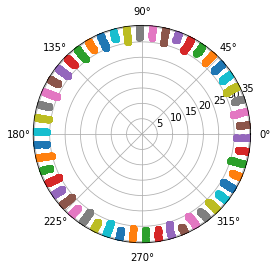

In [10]:
for p, trj_sub in t.groupby("particle"):
    plt.polar(t.loc[idx[:,p],"theta"], t.loc[idx[:,p],"r"], 'o')

In [11]:
t = trj.groupby("frame").apply(sp.set_particle_positions)
t.head()

x          y          r     theta  position
frame particle                                                     
0     0          1.114078 -34.978068  34.995805 -1.538956       1.0
      1        -34.143819   5.381114  34.565254  2.985277      -1.0
      2         33.860501   7.306964  34.639937  0.212537      -1.0
      3        -33.319423   9.696028  34.701541  2.858411      -1.0
      4         32.670976  11.458643  34.622148  0.337324      -1.0

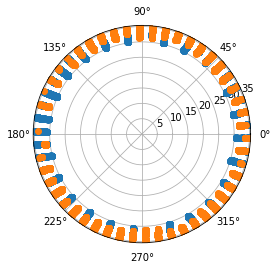

In [12]:
for p, trj_sub in t.groupby("position"):
    plt.polar(trj_sub.loc[idx[:,:],"theta"], trj_sub.loc[idx[:,:],"r"], 'o')

In [13]:
t["domain_walls"] = np.NaN

for f, trj_sub in tqdm_notebook(t.groupby("frame")):
    
    last_particle = trj.index.get_level_values("particle").unique().to_list()[-1]
    t.loc[idx[f,:], "domain_walls"] = t.loc[idx[f,:], "position"].diff()
    t.loc[idx[f,0], "domain_walls"] = t.loc[idx[f,0], "position"]-t.loc[idx[f,last_particle], "position"]
    
t.head()

x          y          r     theta  position  \
frame particle                                                        
0     0          1.114078 -34.978068  34.995805 -1.538956       1.0   
      1        -34.143819   5.381114  34.565254  2.985277      -1.0   
      2         33.860501   7.306964  34.639937  0.212537      -1.0   
      3        -33.319423   9.696028  34.701541  2.858411      -1.0   
      4         32.670976  11.458643  34.622148  0.337324      -1.0   

                domain_walls  
frame particle                
0     0                  0.0  
      1                 -2.0  
      2                  0.0  
      3                  0.0  
      4                  0.0

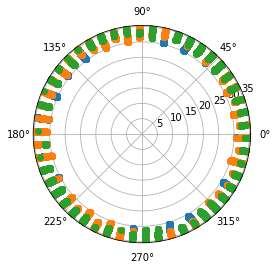

In [14]:
for p, trj_sub in t.groupby("domain_walls"):
    plt.polar(trj_sub.loc[idx[:,:],"theta"], trj_sub.loc[idx[:,:],"r"], 'o')

In [15]:
dom_walls_evo = pd.DataFrame()

for f, trj_sub in t.groupby("frame"):
    dom_walls_evo = dom_walls_evo.append({"frame": f,
                                          "n_walls": t.loc[idx[f,:],"domain_walls"][t.domain_walls==0].count()},
                                          ignore_index=True)
    
#dom_walls_evo = dom_walls_evo.set_index("frame")
dom_walls_evo.head()

,frame,n_walls
0,0.0,36.0
1,1.0,40.0
2,2.0,38.0
3,3.0,40.0
4,4.0,38.0


In [16]:
des_frame = t.index.get_level_values("frame").unique().to_list()[-61]
(t.loc[idx[des_frame,:], "domain_walls"]==0).sum()

24

In [17]:
import scipy.signal
yhat = scipy.signal.savgol_filter(dom_walls_evo.n_walls, 51, 3)

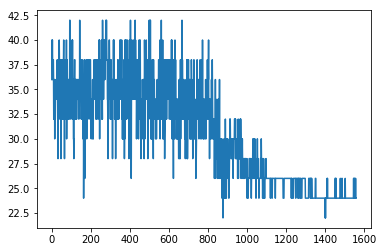

In [18]:
plt.plot(dom_walls_evo.frame, dom_walls_evo.n_walls)

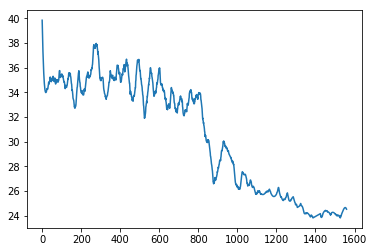

In [19]:
plt.plot(dom_walls_evo.frame, yhat)

### Multi File Process

In [20]:
def find_domain_walls(trj):

    trj["domain_walls"] = np.NaN

    for f, trj_sub in trj.groupby("frame"):

        last_particle = trj.index.get_level_values("particle").unique().to_list()[-1]
        trj.loc[idx[f,:], "domain_walls"] = trj.loc[idx[f,:], "position"].diff()
        trj.loc[idx[f,0], "domain_walls"] = trj.loc[idx[f,0], "position"]-trj.loc[idx[f,last_particle], "position"]
        
    return trj

In [21]:
# def resize_frame_length(trj):
    
#     min_frame = 20000000000000000
#     new_trj = pd.DataFrame()

#     for test, t_sub in preDF.groupby("test_num"):
        
#         if len(t_sub[:,"frame"])<min_frame:
#             min_frame = len(t_sub[:,"frame"])


#     for test, t_sub in preDF.groupby("test_num"):
        
#         new_trj = new_trj.append({"test": [test]*min_frame, "frame": trj[test, "frame"][:min_frame],
#                               "n_walls": trj[test, "n_walls"][:min_frame]}, ignore_index = True)
                     
#     return new_trj

def set_particle_position_multiframe(trj):
    
    trj["position"] = np.NaN
    
    for f in trj.index.get_level_values("frame").unique().to_list():
        
        r_mean = trj.loc[idx[f,:], "r"].mean()
        
        for particle in trj.index.get_level_values("particle").unique().to_list():
        
            if trj.loc[idx[f,particle],"r"] > r_mean:

                trj.loc[idx[f,particle],"position"] = 1

            elif trj.loc[idx[f,particle],"r"] < r_mean:

                trj.loc[idx[f,particle],"position"] = -1

            else:
                trj.loc[idx[f,particle],"position"] = 0
            
    return trj

def sort_particles_in_circle_multiframe(trj):
    
    all_id = pd.DataFrame()
    
    for f in trj.index.get_level_values("frame").unique().to_list():
        
        new_id = trj.loc[idx[f,:],:].sort_values("theta").filter(["theta"])
        new_id["id"] = range(0,len(new_id))
        new_id = new_id.sort_index()
        
        all_id = all_id.append(new_id, ignore_index=True)
        #trj.loc[idx[f,:], :] = trj.loc[idx[f,:], :].index.set_levels(new_id.id, level="particle")

    trj = trj.reset_index()
    trj.particle = all_id.id #new_id.id.values
    trj = trj.set_index(["frame", "particle"]).sort_index()
    
    return trj.sort_index()


In [22]:
def find_lowest_final_frame(trj):
    
    min_frame = 20000000000000000

    for test, t_sub in trj.groupby("test_num"):
        
        if len(t_sub["frame"])<min_frame:
            min_frame = len(t_sub["frame"])
                     
    return min_frame

In [23]:
#omd = pd.DataFrame()
preDF = pd.DataFrame()

i = 0

test = "Test02_"
#video_list = tracking_files
tracking_files = data_selector(test, video_list)
test_num = 0

for tracking_test in tqdm_notebook(tracking_files[:]):

    trj = load_process(tracking_test)
    trj = sort_particles_in_circle_multiframe(trj) #trj.groupby("frame").apply(sp.sort_particles_in_circle)
    trj = set_particle_position_multiframe(trj)
    trj = find_domain_walls(trj)

    for f, trj_sub in trj.groupby("frame"):
        preDF = preDF.append({"test_num": int(test_num), "frame": f, "n_walls": (trj_sub.domain_walls==0).sum()},
                             ignore_index=True)
    
    test_num+=1

preDF = preDF.set_index("test_num")
#preDF = resize_frame_length(preDF) #in order to have the same number of frames for all the experiments of the same test
preDF.head()
#omd = pd_DataFrame({preDF.groupby("frame").n_walls.mean()})

KeyboardInterrupt: 

In [ ]:
import scipy.signal

max_frame = find_lowest_final_frame(preDF)
defect_evo = np.zeros(max_frame)

i = 0
for tst, trj_sub in preDF.groupby("test_num"):
    yhat = scipy.signal.savgol_filter(trj_sub.n_walls, 51, 3)
    defect_evo += yhat[:max_frame]
    plt.plot(trj_sub.frame, yhat)
    i+=1
    
defect_evo = defect_evo/i

In [ ]:
plt.plot(defect_evo)

### Multi test process

In [24]:
#Imports
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook

import pint

import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
directory = r"C:\Users\Eric\Documents\Python_Scripts\Kibbke-Zurek\20191003"

In [26]:
pre_list = sp.get_names(directory,ext = ".dat")

pre_list = pre_list[:]

omit = []

pre_list = [name for name in pre_list if 
     all([os.path.split(name)[-1]!=item for item in omit])]

video_list = pre_list

len(video_list)

1020

In [27]:
tracking_files = []

test_list = ["Test02_", "Test10_", "Test16_"]

for video in video_list:
    
    for test in test_list:
        
        if test in video:
            tracking_files.append(video)
        
len(tracking_files)

180

In [28]:
tracking_files[54]

'C:\\Users\\Eric\\Documents\\Python_Scripts\\Kibbke-Zurek\\20191003\\Tracking_Test02_58'

In [29]:
def load_process(name):
    
    trj = sp.load_data(name) #sp.load_dat(name) #
    trj = sp.from_px_to_um(trj, 0.1805)
    trj = sp.check_N_particles(trj)
    trj = sp.recenter(trj)
    trj = sp.get_polar_coordinates(trj)
    
    return trj

In [30]:
tests_de = pd.DataFrame()

i = 0

test_num = 0

for tracking_test in tqdm_notebook(tracking_files):

    trj = load_process(tracking_test)
    trj = sp.sort_particles_in_circle_multiframe(trj) #trj.groupby("frame").apply(sp.sort_particles_in_circle)
    trj = sp.set_particle_position_multiframe(trj)
    trj = sp.find_domain_walls(trj)

    for f, trj_sub in trj.groupby("frame"):
        tests_de = tests_de.append({"test": tracking_test.split('\\')[-1].split('_')[1][-2:], "test_num": int(test_num),
                              "frame": f, "n_walls": (trj_sub.domain_walls==0).sum()}, ignore_index=True)
    
    test_num+=1 #cambiar esta mierda, tiene que ir de 0 a 60 para cada test

tests_de = tests_de.set_index("test", "test_num")
tests_de.head()

KeyboardInterrupt: 

In [ ]:
tests_de.to_csv("Defects_evolution_20191003_Tests_02_10_16",sep="\t")

### Plot 

In [31]:
#Imports
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook

import scipy.signal

import pint

import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
tests_de = pd.read_csv("Defects_evolution_20191003_Tests_02_10_16",sep="\t")
tests_de = tests_de.set_index(["test", "test_num"])
tests_de.head()

frame  n_walls
test test_num                
2    0.0         0.0     40.0
     0.0         1.0     42.0
     0.0         2.0     42.0
     0.0         3.0     42.0
     0.0         4.0     42.0

In [33]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

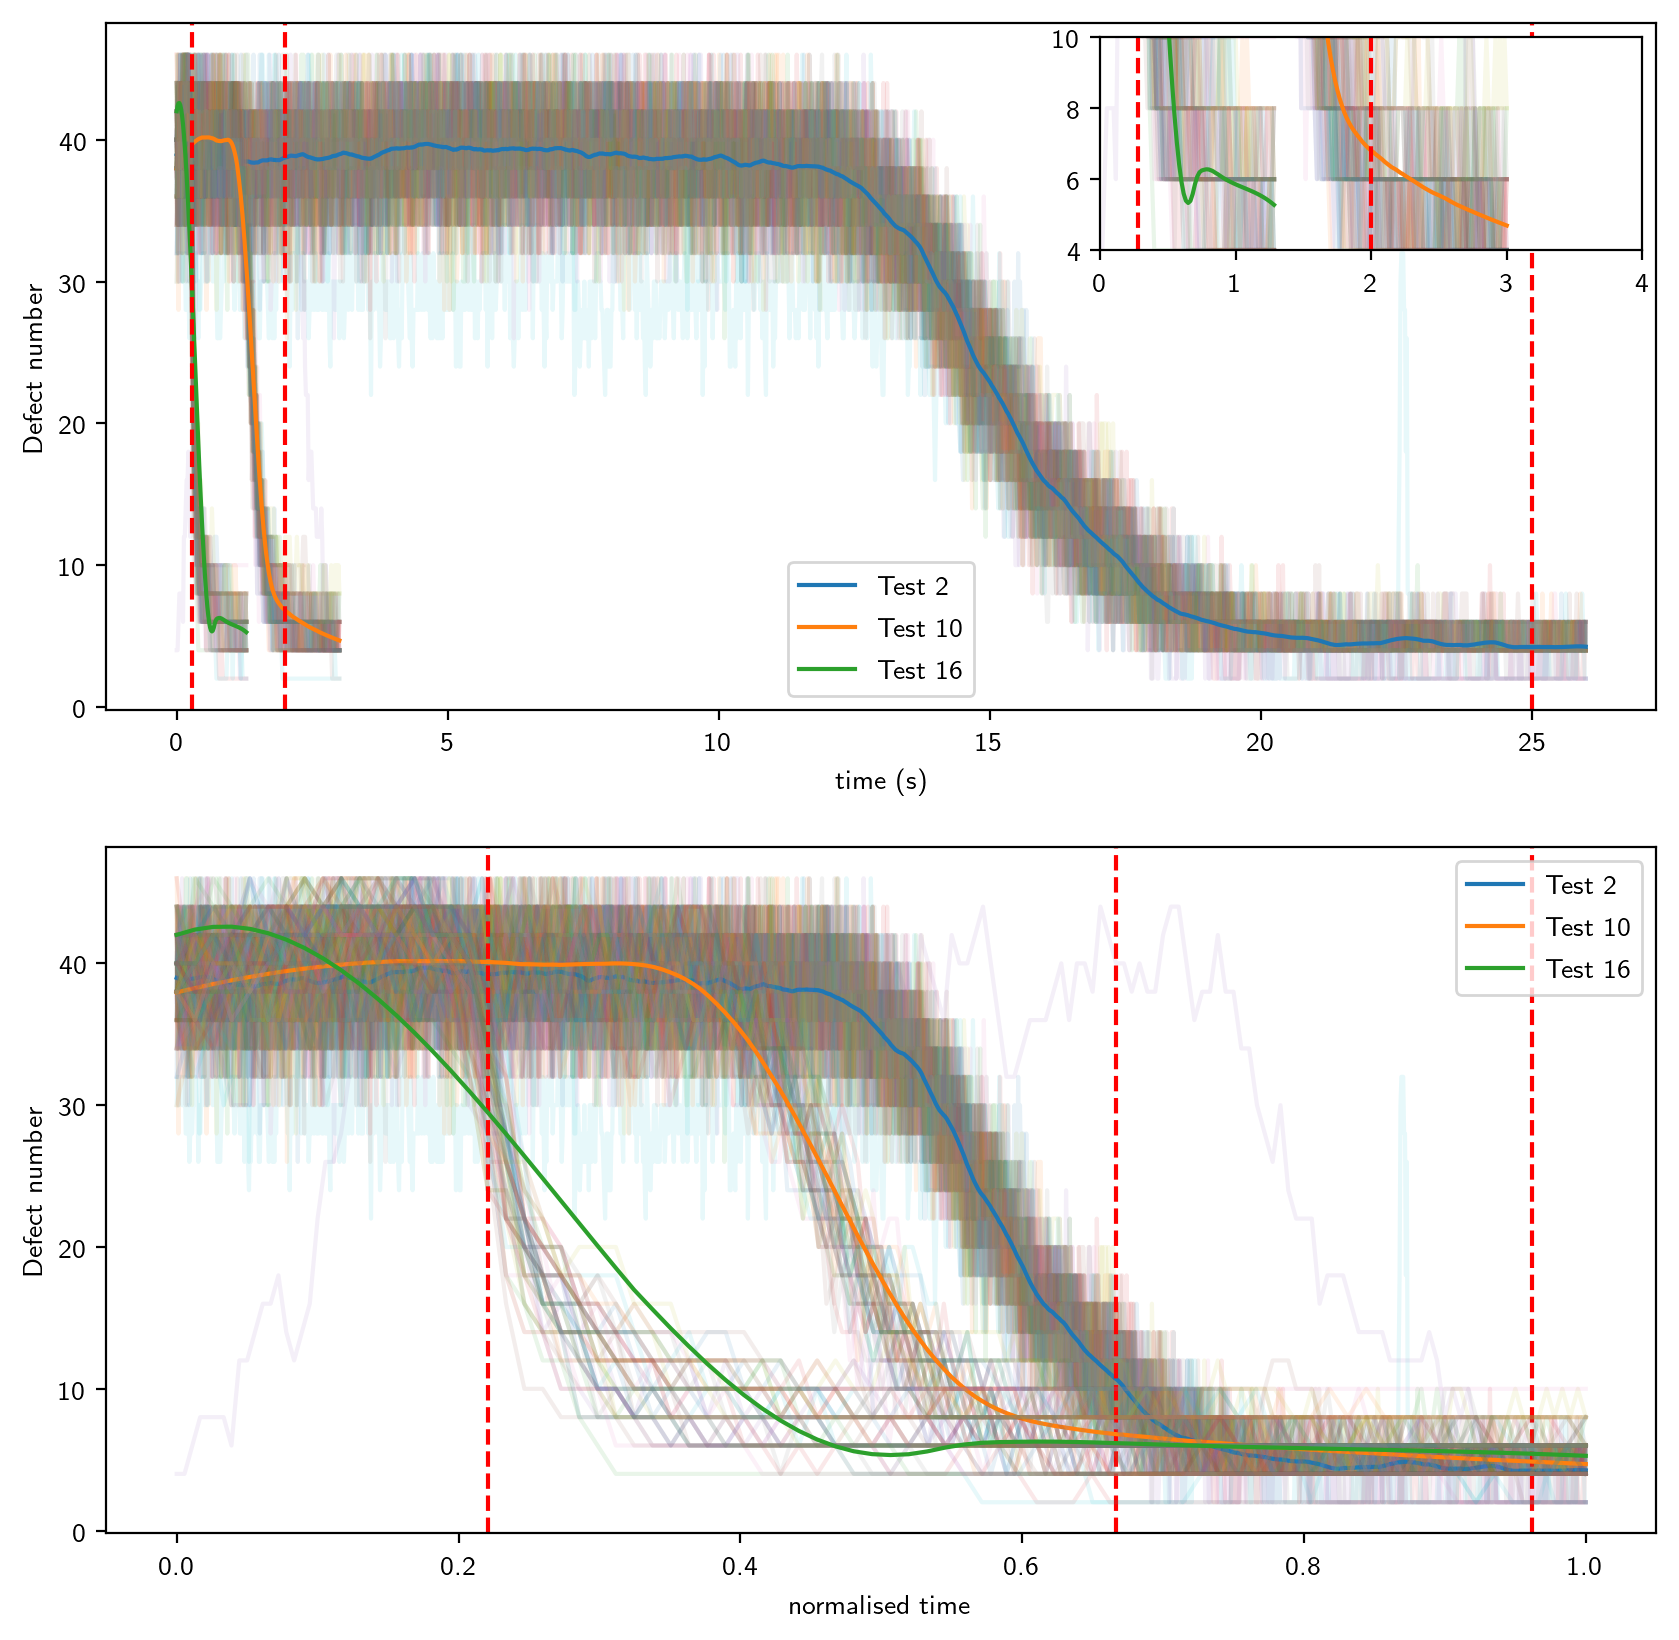

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

fig, ax = plt.subplots(2,1,figsize = (10,10))

axins = zoomed_inset_axes(ax[0], 2.5, loc=1) # zoom-factor: 2.5, location: upper-r
max_frame = 0

for T, t in tests_de.groupby("test"):
      
    max_frame = sp.find_lowest_final_frame(t)
    defect_evo = np.zeros(max_frame)

    time = t.loc[idx[:,:],"frame"].unique()[:max_frame]/60
    norm_time = time/((max_frame-1)/60)
    stop_compress = (max_frame-61)/60
    norm_stop_compress = ((max_frame-61)/60)/((max_frame-1)/60)

    i = 0
    for tst, trj_sub in t.groupby("test_num"):
        yhat = scipy.signal.savgol_filter(trj_sub.n_walls, 51, 3)
        defect_evo += yhat[:max_frame]
        
        ax[0].plot(time, trj_sub.n_walls.values[:max_frame], alpha=0.1)#
        axins.plot(time, trj_sub.n_walls.values[:max_frame], alpha=0.1)
        ax[1].plot(norm_time, trj_sub.n_walls.values[:max_frame], alpha=0.1)
        
        i+=1

    defect_evo = defect_evo/i

    ax[0].plot(time, defect_evo, label="Test {0}".format(T))
    ax[0].axvline(stop_compress, ls="--", c = "r")
    axins.plot(time, defect_evo)
    axins.axvline(stop_compress, ls="--", c = "r")
    
    ax[1].axvline(norm_stop_compress, ls="--", c = "r")
    ax[1].plot(norm_time, defect_evo, label="Test {0}".format(T))
    
ax[0].legend(loc=8)#loc=8)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("Defect number")
axins.set_xlim([0,4])
axins.set_ylim([4,10]);

ax[1].legend()#loc=1)
ax[1].set_xlabel("normalised time")
ax[1].set_ylabel("Defect number");

# Particle and defect trajectories

In [1]:
#Imports
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook

import pint

import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

In [2]:
def load_process(name):
    
    trj = sp.load_data(name) #sp.load_dat(name) #
    trj = sp.from_px_to_um(trj, 0.1805)
    trj = sp.check_N_particles(trj)
    trj = sp.recenter(trj)
    trj = sp.get_polar_coordinates(trj)
    
    return trj

In [3]:
directory = r"C:\Users\Eric\Documents\Python_Scripts\Kibbke-Zurek\20191003"

In [4]:
pre_list = sp.get_names(directory,ext = ".dat")

pre_list = pre_list[:]

omit = []

pre_list = [name for name in pre_list if 
     all([os.path.split(name)[-1]!=item for item in omit])]

video_list = pre_list

len(video_list)

1020

In [5]:
tracking_files = []

test_list = ["Test02_", "Test10_", "Test16_"]

for video in video_list:
    
    for test in test_list:
        
        if test in video:
            tracking_files.append(video)
        
len(tracking_files)

180

In [7]:
tracking_test = tracking_files[136]
tracking_test

'C:\\Users\\Eric\\Documents\\Python_Scripts\\Kibbke-Zurek\\20191003\\Tracking_Test16_23'

In [8]:
trj = load_process(tracking_test)
trj = sp.sort_particles_in_circle_multiframe(trj) #trj.groupby("frame").apply(sp.sort_particles_in_circle)
trj = sp.set_particle_position_multiframe(trj)
trj = sp.find_domain_walls(trj)
trj.head()

x          y          r     theta  position  \
frame particle                                                        
0     0        -34.474401  -3.380212  34.639719 -3.043855      -1.0   
      1        -33.836795  -7.721792  34.706696 -2.917228      -1.0   
      2        -32.679084 -11.871682  34.768655 -2.793136       1.0   
      3        -30.833082 -15.946998  34.712904 -2.664277      -1.0   
      4        -28.665607 -19.548647  34.696781 -2.543081      -1.0   

                domain_walls  
frame particle                
0     0                  0.0  
      1                  0.0  
      2                  2.0  
      3                 -2.0  
      4                  0.0

In [9]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

In [10]:
max_frame = trj.index.get_level_values("frame").unique().to_list()[-1]
stop_compress = (max_frame-61)/60

Text(0.5, 0, 'time (s)')

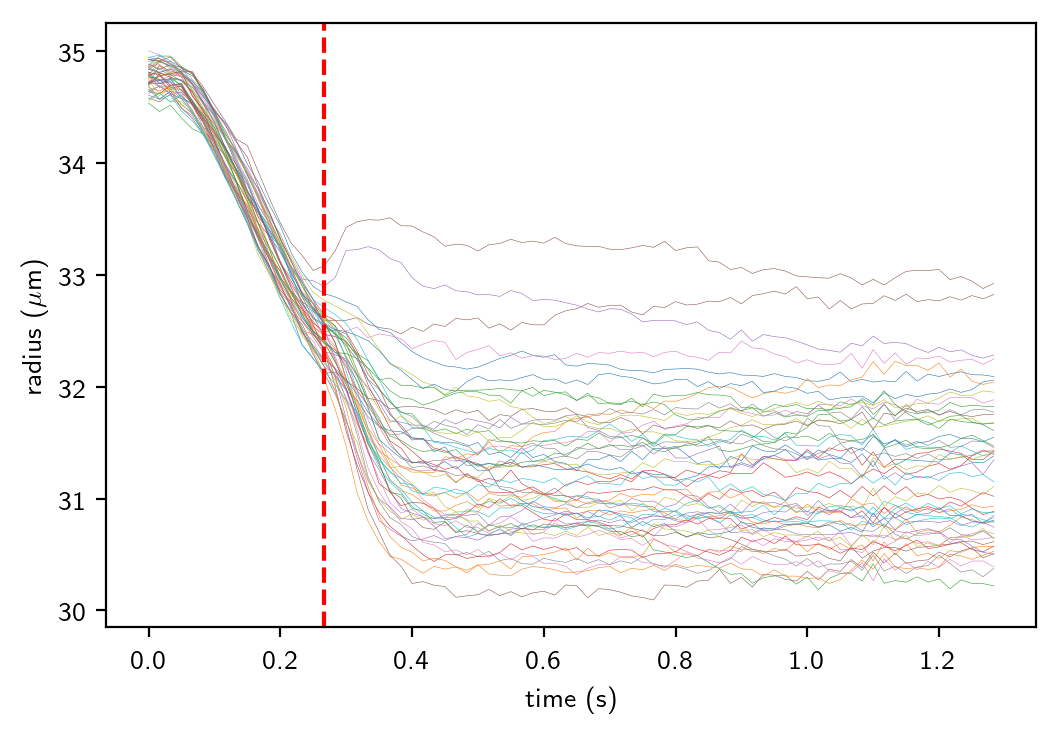

In [11]:
for p, trj_sub in trj.groupby("particle"):
    plt.plot(trj_sub.index.get_level_values("frame")/60, trj_sub.r.values, lw = .2);

plt.axvline(stop_compress, ls="--", c = "r")
plt.ylabel(r"radius ($\mu$m)")
plt.xlabel("time (s)")

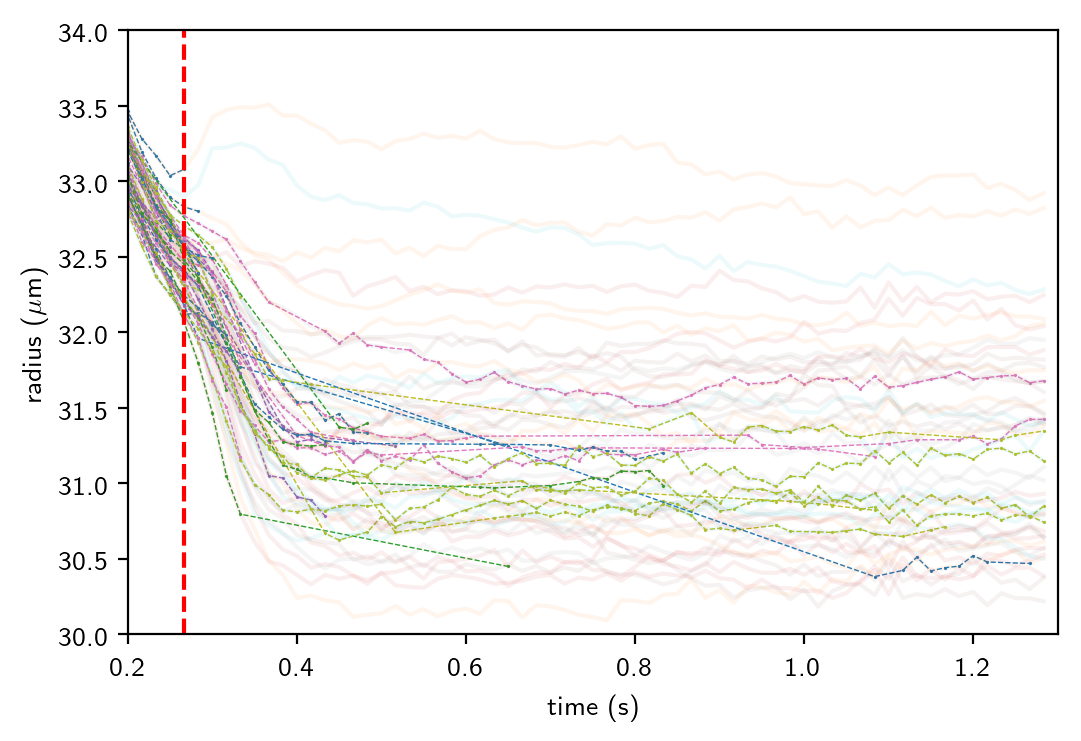

In [20]:
for p, trj_sub in trj.groupby("particle"):
    defect_df = trj_sub[trj_sub.domain_walls==0]
    plt.plot(defect_df.index.get_level_values("frame")/60, defect_df.r, '--*', lw=.5, ms=0.5)
    plt.plot(trj_sub.index.get_level_values("frame")/60, trj_sub.r.values, alpha=.075);
    
plt.axvline(stop_compress, ls="--", c = "r")

plt.xlim([0.2, 1.3])#, 26.1]);
plt.ylim([30,34]);
plt.ylabel("radius ($\mu$m)")
plt.xlabel("time (s)");

Appearing and dissapearing of defects in time. Plot theta values of defects.

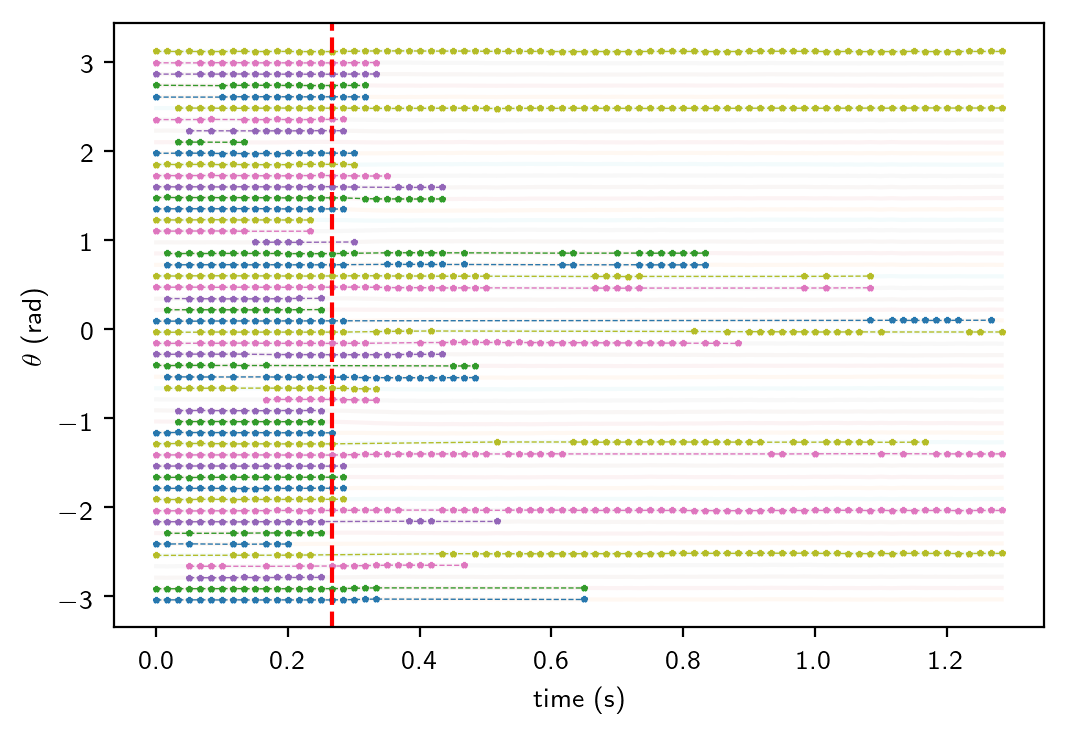

In [13]:
for p, trj_sub in trj.groupby("particle"):
    defect_df = trj_sub[trj_sub.domain_walls==0]
    plt.plot(defect_df.index.get_level_values("frame")/60, defect_df.theta, '--*', lw=.5, ms=2)
    plt.plot(trj_sub.index.get_level_values("frame")/60, trj_sub.theta, alpha=.05);
    
plt.axvline(stop_compress, ls="--", c = "r")
plt.ylabel(r"$\theta$ (rad)")
plt.xlabel("time (s)");

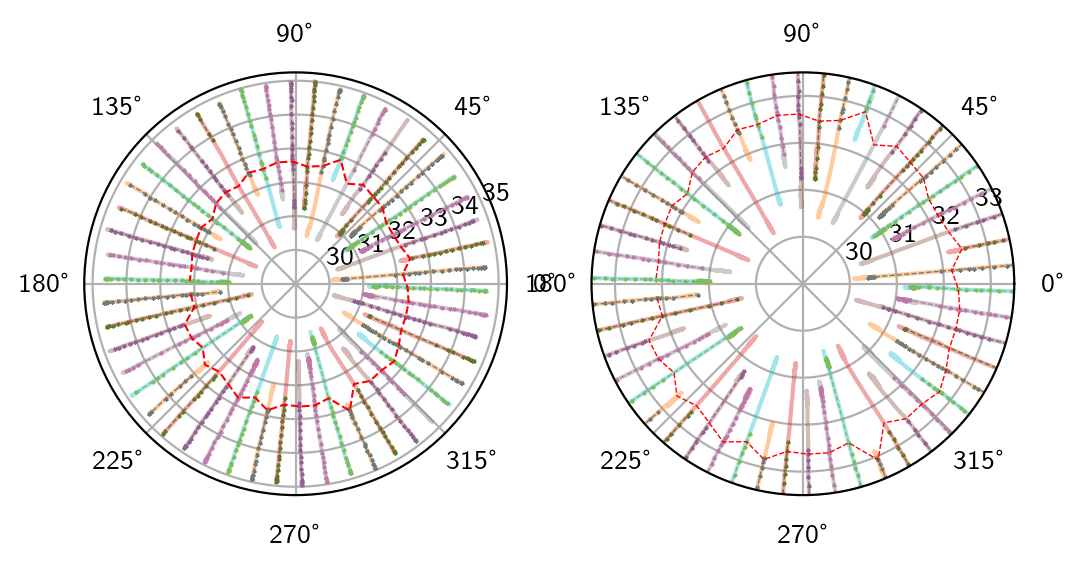

In [14]:
fig, ax = plt.subplots(1,2, subplot_kw=dict(polar=True))

for p, trj_sub in trj.groupby("particle"):
    defect_df = trj_sub[trj_sub.domain_walls==0]
    ax[0].plot(defect_df.theta, defect_df.r, '--*', lw=.5, ms=1)
    ax[0].plot(trj_sub.theta, trj_sub.r, alpha=.4);
    ax[1].plot(defect_df.theta, defect_df.r, '--*', lw=.5, ms=1)
    ax[1].plot(trj_sub.theta, trj_sub.r, alpha=.4);
    
r32_line = [32]*100 
r31_line = [31]*100 
theta_line = 2*np.pi*np.linspace(0,1,100)
r_compress = trj.loc[idx[max_frame-61, :], "r"]
theta_compress = trj.loc[idx[max_frame-61, :], "theta"]
# ax[0].plot(theta_line, r32_line,'r--', lw = 0.75)
# ax[0].plot(theta_line, r31_line,'b--', lw = 0.75)
ax[0].plot(theta_compress, r_compress,'r--', lw = 0.75)
ax[1].plot(theta_compress, r_compress,'r--', lw = 0.5)
ax[0].set_rmin(29)
ax[1].set_rmin(29)
ax[1].set_rmax(33.5)
ax[1].set_rticks([30, 31, 32, 33]);